# Introduction

Recall from the example in the previous lesson that Keras will keep a history of the training and validation loss over the epochs that it is training the model. In this lesson, we're going to learn how to interpret these learning curves and how we can use them to guide model development. In particular, we'll examine at the learning curves for evidence of underfitting and overfitting and look at a couple of strategies for correcting it.

# Interpreting the Learning Curves

You might think about the information in the training data as being of two kinds: **signal and noise**. The **signal** is the part that generalizes, the part that can help our model make predictions from new data. The **noise** is that **part that is only true of the training data**; the noise is all of the random fluctuation that comes from data in the real-world or all of the incidental, non-informative patterns that can't actually help the model make predictions. The noise is the part might look useful but really isn't.

We train a model by choosing weights or parameters that minimize the loss on a training set. You might know, however, that to accurately assess a model's performance, we need to evaluate it on a new set of data, the validation data. (You could see our lesson on model validation in Introduction to Machine Learning for a review.)

When we train a model we've been plotting the loss on the training set epoch by epoch. To this we'll add a plot the validation data too. These plots we call the learning curves. To train deep learning models effectively, we need to be able to interpret them.

<img src="https://i.imgur.com/tHiVFnM.png"/>

**The validation loss gives an estimate of the expected error on unseen data.**

Now, the training loss will go down either when the model learns signal or when it learns noise. **But the validation loss will go down only when the model learns signal**. (Whatever noise the model learned from the training set won't generalize to new data.) So, when a model learns signal both curves go down, ***but when it learns noise a gap is created in the curves*. The size of the gap tells you how much noise the model has learned**.

Ideally, we would create models that learn all of the signal and none of the noise. This will practically never happen. Instead we make a trade. We can get the model to learn more signal at the cost of learning more noise. So long as the trade is in our favor, the validation loss will continue to decrease. After a certain point, however, the trade can turn against us, the cost exceeds the benefit, and the validation loss begins to rise.

<img src="https://i.imgur.com/eUF6mfo.png"/>

This trade-off indicates that there can be two problems that occur when training a model: not enough signal or too much noise. **Underfitting the training set is when the loss is not as low as it could be because the model hasn't learned enough signal**. **Overfitting the training set is when the loss is not as low as it could be because the model learned too much noise**. The trick to training deep learning models is finding **the best balance between the two**.

We'll look at a couple ways of getting more signal out of the training data while reducing the amount of noise.

# Capacity

**A model's *capacity* refers to the size and complexity of the patterns it is able to learn.**

For neural networks, this will largely be **determined by how many neurons it has and how they are connected together**. If it appears that your network is underfitting the data, you should try increasing its capacity.

You can increase the capacity of a network either by making it wider (more units to existing layers) or by making it deeper (adding more layers). Wider networks have an easier time learning more linear relationships, while deeper networks prefer more nonlinear ones. Which is better just depends on the dataset.

'''
    
    model = keras.Sequential([
        layers.Dense(16, activation='relu'),
        layers.Dense(1),
    ])

    wider = keras.Sequential([
        layers.Dense(32, activation='relu'),
        layers.Dense(1),
    ])

    deeper = keras.Sequential([
        layers.Dense(16, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(1),
    ])
'''

You'll explore how the capacity of a network can affect its performance in the exercise.

# Early Stopping

We mentioned that when a model is too eagerly learning noise, the validation loss may start to increase during training. To prevent this, **we can simply stop the training whenever it seems the validation loss isn't decreasing anymore**. Interrupting the training this way is called **early stopping**.

<img src="https://i.imgur.com/eP0gppr.png"/>

*We keep the model where the validation loss is at a minimum.*

Once we detect that the validation loss is starting to rise again, we can reset the weights back to where the minimum occured. This ensures that the model won't continue to learn noise and overfit the data.

Training with early stopping also means we're in less danger of stopping the training too early, before the network has finished learning signal. **So besides preventing overfitting from training too long, early stopping can also prevent underfitting from not training long enough**. Just set your training epochs to some large number (more than you'll need), and early stopping will take care of the rest.

# Adding Early Stopping

In Keras, we include early stopping in our training through a callback. A callback is just a function you want run every so often while the network trains. The early stopping callback will run after every epoch. (Keras has a variety of useful callbacks pre-defined, but you can define your own, too.)


In [1]:
from tensorflow.keras.callbacks import EarlyStopping # Stop training when a monitored metric has stopped improving.

In [2]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True
)

These parameters say: "If there hasn't been at least an improvement of 0.001 in the validation loss over the previous 20 epochs, then stop the training and keep the best model you found." It can sometimes be hard to tell if the validation loss is rising due to overfitting or just due to random batch variation. **The parameters allow us to set some allowances around when to stop**.

As we'll see in our example, we'll pass this callback to the fit method along with the loss and optimizer.

# Example - Train a Model with Early Stopping

Let's continue developing the model from the example in the last tutorial. We'll increase the capacity of that network but also add an early-stopping callback to prevent overfitting.

Here's the data prep again.

In [4]:
import pandas as pd

red_wine = pd.read_csv('data/red-wine.csv')

red_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [7]:
# Create training and validation splits (70% train)
df_train = red_wine.sample(frac=0.7, random_state=0)
df_valid = red_wine.drop(df_train.index) # removing the rows that was selected to insert in the df_train
df_train.head(4)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1109,10.8,0.470,0.43,2.10,0.171,27.0,66.0,0.99820,3.17,0.76,10.8,6
1032,8.1,0.820,0.00,4.10,0.095,5.0,14.0,0.99854,3.36,0.53,9.6,5
1002,9.1,0.290,0.33,2.05,0.063,13.0,27.0,0.99516,3.26,0.84,11.7,7
487,10.2,0.645,0.36,1.80,0.053,5.0,14.0,0.99820,3.17,0.42,10.0,6


In [9]:
# Scale to [0, 1] all of the collunms
max_ = df_train.max(axis=0)
min_ = df_train.min(axis=0)
df_train = (df_train - min_) / (max_ - min_)
df_valid = (df_valid - min_) / (max_ - min_)

In [10]:
# Split features and target
X_train = df_train.drop('quality', axis=1)
y_train = df_train['quality']
X_valid = df_valid.drop('quality', axis=1)
y_valid = df_valid['quality']

Now let's increase the capacity of the network. We'll go for a fairly large network, but rely on the callback to halt the training once the validation loss shows signs of increasing.

In [11]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks

patience: Number of epochs with no improvement
      after which training will be stopped.

In [13]:
# Creating the callback for early stopping
early_stop = callbacks.EarlyStopping (min_delta=0.001, patience=20, restore_best_weights=True)

In [18]:
model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1)
])

In [19]:
model.compile(
    optimizer='adam',
    loss='mae'
)

After defining the callback, add it as an argument in fit (you can have several, so put it in a list). Choose a large number of epochs when using early stopping, more than you'll need.

In [20]:
history = model.fit(
    X_train, y_train, 
    validation_data=(X_valid, y_valid),
    batch_size = 256, 
    epochs=500, 
    callbacks=[early_stop], 
    verbose=True, 
)

Epoch 1/500
5/5 [==============================] - 4s 99ms/step - loss: 0.2966 - val_loss: 0.1427
Epoch 2/500
5/5 [==============================] - 0s 30ms/step - loss: 0.1406 - val_loss: 0.1301
Epoch 3/500
5/5 [==============================] - 0s 27ms/step - loss: 0.1273 - val_loss: 0.1182
Epoch 4/500
5/5 [==============================] - 0s 26ms/step - loss: 0.1170 - val_loss: 0.1101
Epoch 5/500
5/5 [==============================] - 0s 29ms/step - loss: 0.1109 - val_loss: 0.1068
Epoch 6/500
5/5 [==============================] - 0s 30ms/step - loss: 0.1086 - val_loss: 0.1022
Epoch 7/500
5/5 [==============================] - 0s 26ms/step - loss: 0.1043 - val_loss: 0.1043
Epoch 8/500
5/5 [==============================] - 0s 28ms/step - loss: 0.1036 - val_loss: 0.1032
Epoch 9/500
5/5 [==============================] - 0s 25ms/step - loss: 0.1028 - val_loss: 0.1003
Epoch 10/500
5/5 [==============================] - 0s 25ms/step - loss: 0.1010 - val_loss: 0.1014
Epoch 11/500
5/5 [=

In [23]:
history_df = pd.DataFrame(history.history)

In [25]:
history_df.head()

,loss,val_loss
0,0.296605,0.142727
1,0.140557,0.130101
2,0.127261,0.118222
3,0.116952,0.110142
4,0.110940,0.106812


<AxesSubplot:>

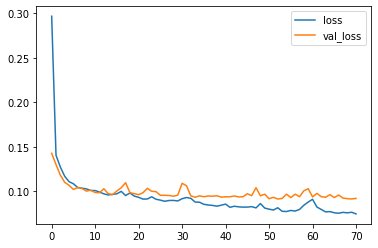

In [26]:
history_df.loc[:, ['loss', 'val_loss']].plot()

In [27]:
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

Minimum validation loss: 0.09146713465452194


And sure enough, Keras stopped the training well before the full 500 epochs!



# Exercise

In [28]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

First load the Spotify dataset. Your task will be to predict the **popularity** of a song based on various audio features, like 'tempo', 'danceability', and 'mode'.

StandardScaler = Standardize features by removing the mean and scaling to unit variance.

The standard score of a sample x is calculated as: z = (x - u) / s. Z-score

Many machine learning algorithms perform better when numerical input variables are scaled to a standard range.

This includes algorithms that use a weighted sum of the input, like linear regression, and algorithms that use distance measures, like k-nearest neighbors. The two most popular techniques for scaling numerical data prior to modeling are normalization and standardization. Normalization scales each input variable separately to the range 0-1, which is the range for floating-point values where we have the most precision. Standardization scales each input variable separately by subtracting the mean (called centering) and dividing by the standard deviation to shift the distribution to have a mean of zero and a standard deviation of one. More information here: https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/

In [29]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

In [30]:
# Tensorflow imports
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

In [32]:
spotify = pd.read_csv('data/spotify.csv')

In [33]:
spotify.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


In [34]:
spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-null  int64  
 14  loudne

In [35]:
# there's no null, but use this command anyway
X = spotify.copy().dropna()
y = X.pop('track_popularity') # remove target from X and also returns it to y

In [36]:
y

0        66
1        67
2        70
3        60
4        69
         ..
32828    42
32829    20
32830    14
32831    15
32832    27
Name: track_popularity, Length: 32828, dtype: int64

In [37]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32828 entries, 0 to 32832
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32828 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_album_id            32828 non-null  object 
 4   track_album_name          32828 non-null  object 
 5   track_album_release_date  32828 non-null  object 
 6   playlist_name             32828 non-null  object 
 7   playlist_id               32828 non-null  object 
 8   playlist_genre            32828 non-null  object 
 9   playlist_subgenre         32828 non-null  object 
 10  danceability              32828 non-null  float64
 11  energy                    32828 non-null  float64
 12  key                       32828 non-null  int64  
 13  loudness                  32828 non-null  float64
 14  mode  

In [38]:
artists = X['track_artist']

In [39]:
features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

In [40]:
preprocessor = make_column_transformer(
    (StandardScaler(), features_num), # fazer o stardard scaler in the features num
    (OneHotEncoder(), features_cat), # fazer o one hot encoder in categoricals
)

In [41]:
# We'll do a "grouped" split to keep all of an artist's songs in one
# split or the other. This is to help prevent signal leakage.
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

In [42]:
X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

In [44]:
X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100 # popularity is on a scale 0-100, so this rescales to 0-1.
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


Let's start with the simplest network, a linear model. This model has low capacity.

Run this next cell without any changes to train a linear model on the Spotify dataset.

Minimum Validation Loss: 0.1993


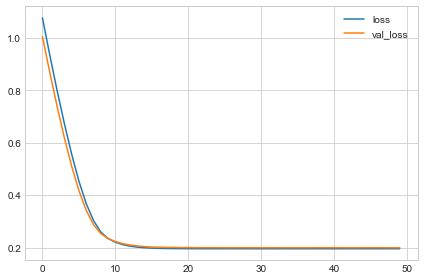

In [45]:
model = keras.Sequential([
    layers.Dense(1, input_shape=input_shape),
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0, # suppress output since we'll plot the curves
)
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

It's not uncommon for the curves to follow a "hockey stick" pattern like you see here. This makes the final part of training hard to see, so let's start at epoch 10 instead:

Minimum Validation Loss: 0.1993


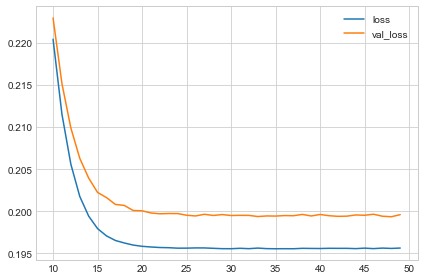

In [46]:
# Start the plot at epoch 10
history_df.loc[10:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

# 1) Evaluate Baseline

What do you think? Would you say this model is underfitting, overfitting, just right?

**The gap between these curves is quite small and the validation loss never increases, so it's more likely that the network is underfitting than overfitting. It would be worth experimenting with more capacity to see if that's the case.**

Now let's add some capacity to our network. We'll add three hidden layers with 128 units each. Run the next cell to train the network and see the learning curves.

Epoch 1/50
49/49 [==============================] - 1s 8ms/step - loss: 0.2840 - val_loss: 0.2125
Epoch 2/50
49/49 [==============================] - 0s 4ms/step - loss: 0.2028 - val_loss: 0.2050
Epoch 3/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1972 - val_loss: 0.2030
Epoch 4/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1936 - val_loss: 0.2018
Epoch 5/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1912 - val_loss: 0.2015
Epoch 6/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1892 - val_loss: 0.2009
Epoch 7/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1883 - val_loss: 0.2013
Epoch 8/50
49/49 [==============================] - 0s 5ms/step - loss: 0.1867 - val_loss: 0.2017
Epoch 9/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1859 - val_loss: 0.2000
Epoch 10/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1848 - val_loss: 0.2007
Epoch 11/50
49/49 [

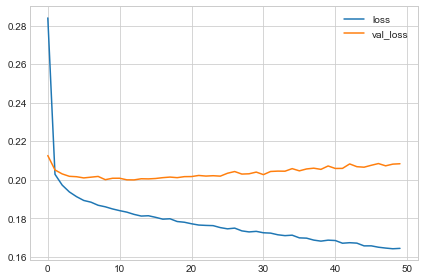

In [47]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

# 2) Add Capacity

What is your evaluation of these curves? Underfitting, overfitting, just right?

**Now the validation loss begins to rise very early, while the training loss continues to decrease. This indicates that the network has begun to overfit. At this point, we would need to try something to prevent it, either by reducing the number of units or through a method like early stopping. (We'll see another in the next lesson!)**

# 3) Define Early Stopping Callback

Now define an early stopping callback that waits 5 epochs (`patience'`) for a change in validation loss of at least `0.001` (`min_delta`) and keeps the weights with the best loss (`restore_best_weights`).

In [48]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(min_delta=0.001, patience=5, restore_best_weights=True)


Epoch 1/50
49/49 [==============================] - 13s 6ms/step - loss: 0.2648 - val_loss: 0.2149
Epoch 2/50
49/49 [==============================] - 0s 4ms/step - loss: 0.2036 - val_loss: 0.2072
Epoch 3/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1970 - val_loss: 0.2036
Epoch 4/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1936 - val_loss: 0.2016
Epoch 5/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1909 - val_loss: 0.2023
Epoch 6/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1894 - val_loss: 0.2017
Epoch 7/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1884 - val_loss: 0.2023
Epoch 8/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1867 - val_loss: 0.2012
Epoch 9/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1862 - val_loss: 0.2025
Minimum Validation Loss: 0.2012


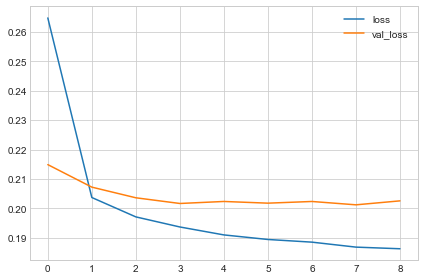

In [49]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

# 4) Train and Interpret

Was this an improvement compared to training without early stopping?

**The early stopping callback did stop the training once the network began overfitting. Moreover, by including restore_best_weights we still get to keep the model where validation loss was lowest.**